In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.axes as axes
import math
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output

# Data import

In [2]:
path = "YOUR_PATH"

In [3]:
#Interes rate: REMIND model: https://db1.ene.iiasa.ac.at/ADVANCEDB/dsd?Action=htmlpage&page=about
ir = pd.read_excel("{}DATA.xlsm".format(path), index_col = False, sheet_name =8)

In [4]:
ir

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,1.05,1.1025,1.157625,1.215506,1.276282,1.340096,1.4071,1.477455,1.551328,1.628895,...,33.545134,35.222391,36.98351,38.832686,40.77432,42.813036,44.953688,47.201372,49.561441,52.039513


In [5]:
#Data from: 
#A matrix: https://fdokument.com/reader/full/fakten-stahlindustrie-2017-stahl-2-fakten-zur-stahlindustrie-2017-inhalt | https://www.bmwi.de/Redaktion/DE/Downloads/E/energiewende-in-der-industrie-ap2a-branchensteckbrief-stahl.pdf?__blob=publicationFile&v=4	
#B matrix: https://www.bmwi.de/Redaktion/DE/Downloads/E/energiewende-in-der-industrie-ap2a-branchensteckbrief-stahl.pdf?__blob=publicationFile&v=4
#Q matrix: http://unfccc.int/process/transparency-and-reporting/greenhouse-gas-data/greenhouse-gas-data-unfccc/global-warming-potentials
#Ore prices: https://www.fitchsolutions.com/products/industry-research
#Steal demand: https://www.europarl.europa.eu/RegData/etudes/STUD/2021/690008/EPRS_STU(2021)690008_EN.pdf
#Coal prices: https://www.iea.org/reports/coal-2020/prices-and-costs
#H2 prices: https://data.bloomberglp.com/professional/sites/24/BNEF-Hydrogen-Economy-Outlook-Key-Messages-30-Mar-2020.pdf

raw = pd.read_excel("{}DATA.xlsm".format(path), index_col =0 , sheet_name =[1, 2, 3, 4, 5, 6, 7])

In [6]:
A = raw[1]
f = raw[2]
F = raw[3]
p = raw[4]
B = raw[5]
c = raw[6]
Q = raw[7]

In [7]:
p.head()

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Provide ore ($ / t),155.0,144.700000,134.400000,124.1,113.800000,103.500000,93.2,82.900000,72.600000,62.3,...,49.385714,49.342857,49.300,49.257143,49.214286,49.171429,49.128571,49.085714,49.042857,49.0
Provide coal ($ / t),105.0,105.333333,105.666667,106.0,106.333333,106.666667,107.0,107.333333,107.666667,108.0,...,143.700000,144.400000,145.100,145.800000,146.500000,147.200000,147.900000,148.600000,149.300000,150.0
Provide H2 ($ / kg),3.6,3.500000,3.400000,3.3,3.200000,3.100000,3.0,2.900000,2.800000,2.7,...,1.354000,1.348000,1.342,1.336000,1.330000,1.324000,1.318000,1.312000,1.306000,1.3
Provide electricity ($/ kWh),0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Buy CO2 price ($ / t),0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [8]:
#data from the ADVANCE project: https://db1.ene.iiasa.ac.at/ADVANCEDB/dsd?Action=htmlpage&page=welcome
raw_energy = pd.read_excel("{}energy_costs.xlsx".format(path))
raw_energy = raw_energy.iloc[0, 8:-1].to_frame().reindex(index = list(range(2020, 2101)))


#Sceneario selction: the most ambitious mitigation scenario for all SSPs
raw_carbon = pd.read_excel("{}carbon_prices.xlsx".format(path), index_col = "Scenario")
raw_carbon = raw_carbon.iloc[0:5, 6:-1].transpose().reindex(index = list(range(2020, 2101)))


In [9]:
ts = pd.to_numeric(raw_energy.iloc[:, 0])

ts = ts.interpolate()

energy_p = ts * 1/277.778 * 1/math.pow(ir.iloc[0,0], 5)

# Preparing price vectors scenario-wise

In [10]:
#energy prices available only in general (not SSP-specific)
p.loc["Provide electricity ($/ kWh)", :]  = energy_p

In [11]:
carbon_p = (raw_carbon.interpolate() * 1/ math.pow(ir.iloc[0,0], 5)).transpose()

In [12]:
p_ssp1 = p.copy()
p_ssp2 = p.copy()
p_ssp3 = p.copy()
p_ssp4 = p.copy()
p_ssp5 = p.copy()

In [13]:
#every scenario has specific emission prices 
p_ssp1.loc["Buy CO2 price ($ / t)", :] = carbon_p.copy().loc["SSP1-19", :]

In [14]:
p_ssp2.loc["Buy CO2 price ($ / t)", :] = carbon_p.copy().loc["SSP2-19", :]

In [15]:
p_ssp3.loc["Buy CO2 price ($ / t)", :] = carbon_p.copy().loc["SSP3-34", :]

In [16]:
p_ssp4.loc["Buy CO2 price ($ / t)", :] = carbon_p.copy().loc["SSP4-26", :]

In [17]:
p_ssp5.loc["Buy CO2 price ($ / t)", :] = carbon_p.loc["SSP5-19", :]

In [18]:
p_list = [("ssp1", p_ssp1), ("ssp2", p_ssp2),("ssp3", p_ssp3), ("ssp4", p_ssp4), ("ssp5", p_ssp5)]

# Optimization model

In [19]:
#demand
y = f

In [20]:
#the processes that should be scaled optimally
Processes = ["Conventional process", "Directreduction", "Ore dummy", "Coal dummy 1", "H2 dummy", "electrcity dummy"]
Flows = f.index.to_list()
demand = []
for v in f.values:
    demand.append(v[0])

In [21]:
#initialize the model and initialize
mdl = pyo.ConcreteModel()
mdl.P = pyo.Set(initialize=Processes)
mdl.f = pyo.Set(initialize=Flows)
mdl.s_p = pyo.Var(mdl.P, domain=pyo.NonNegativeIntegers)

In [22]:
#A * s have to equal the final demand y 
def demand_rule(mdl):
    for n, flow  in enumerate(A.index):
        return sum(mdl.s_p[pr] * A.loc[flow, pr] for pr in mdl.P) >= demand[n]

mdl.demand_restriction = pyo.Constraint(rule=demand_rule)

In [23]:
#find solver
solvername='glpk'
solverpath_folder= "/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/pyomo/solvers/plugins/solvers"

In [24]:
#prepare data frames for vizualization 
cost_results =  pd.DataFrame(index=[ssp for ssp, prices in p_list], columns=[year for year in list(range(2020, 2101))])
process_results =  pd.DataFrame(index=[ssp for ssp, prices in p_list], columns=[year for year in list(range(2020, 2101))])

#solve the model for every year (2020-2100) and scenario (SSP1-SSP5)
for (name, prices) in p_list: 
    for year in list(range(prices.shape[1])):
        
        #minimize costs according to: scaling_vector * factor_requirements * factor_prices (transposed) 
        #to optimizise, how often, which process should be excecuted
        def min_costs(mdl): 
            mult = F.transpose().values @ prices.iloc[:,year].to_frame().values

            return sum(mdl.s_p[pr] * mult[n][0] for n, pr in enumerate(Processes[:-1]))

        mdl.Obj = pyo.Objective(rule=min_costs, sense=pyo.minimize)

        #prepare solver
        optimizer = opt.SolverFactory(solvername) 
        solved_model = optimizer.solve(mdl)
        
        #prepare data frames for vizualization 
        cost_results.loc[name, (2020 + year)] = round(mdl.Obj.expr(),2)
        
        if pyo.value(mdl.s_p["Conventional process"]) > 0:
            process_results.loc[name, (2020 + year)] = pyo.value(mdl.s_p["Directreduction"]) / pyo.value(mdl.s_p["Conventional process"])
        else:
            process_results.loc[name, (2020 + year)] = 1
        
        clear_output(wait=True)

        #print results
        print("Optimal value: %i$" % pyo.value(mdl.Obj)) #threshold to avoid numerical issues
        EPS = 1.e-6

        for pr in ["Directreduction", "Conventional process"]:
            if pyo.value(mdl.s_p[pr]) > EPS:
                print("run the processes according to: %s" % (pyo.value(mdl.s_p[pr])) + " " + str( pr))



Optimal value: 85472017464$
run the processes according to: 158000000.0 Directreduction



# Results

In [25]:
#[0, 1] shows the percentage of the climate friendly "Direct reduction" process 
process_results

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
ssp1,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ssp2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ssp3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ssp4,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ssp5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [26]:
#prepare anuual discount factor based on interest rate
ir_df = pd.DataFrame(index=cost_results.index, columns=ir.columns)
for line in ir_df.index:
    ir_df.loc[line] = ir.values

In [27]:
discounted_costs = cost_results.divide(ir_df)

In [28]:
cost_results.columns

Int64Index([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
            2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
            2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
            2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
            2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
            2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
            2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
            2097, 2098, 2099, 2100],
           dtype='int64')

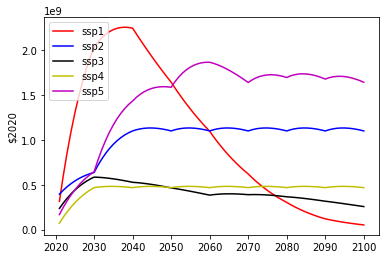

In [29]:
#plot annual discounted costs scenario-wise
df = discounted_costs.iloc[:, 1:].transpose()

color_dict = {'ssp1': "r", "ssp2" : "b", "ssp3" : "k", "ssp4" : "y", "ssp5" : "m"}

plot = df.plot(color=[color_dict[column] for column in df.columns])
plot.set_ylabel("$2020")
plot.get_figure().savefig("costs_annual.png")


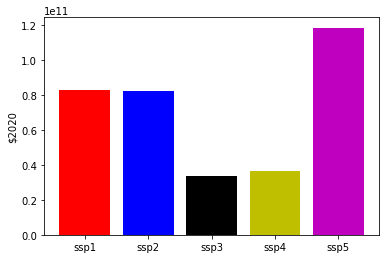

In [30]:
#plot sum of discounted costs scenario-wise
fig, ax = mpl.subplots()
mpl.bar(cost_results.index, discounted_costs.sum(1), color= [color_dict[column] for column in df.columns])
ax.set_ylabel(ylabel="$2020")

mpl.savefig('costs_sum.png')
